In [1]:
# https://www.tensorflow.org/tutorials/keras/regression#split_features_from_labels

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.__version__)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-05-30 17:05:33.960005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:05:34.686746: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-30 17:05:36.248449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs:/h

2.10.0


In [3]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [4]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
dataset = nam_fcast_and_error_df.copy()
dataset = dataset.reset_index()

# add time features
dataset["day_of_year"] = dataset["valid_time"].dt.day_of_year
dataset["hour_of_day"] = dataset["valid_time"].dt.hour
dataset = dataset.set_index(["time", "station", "valid_time"])

In [5]:
dataset.head()

t2m_NAM    d2m_NAM  \
time                station valid_time                                  
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00 -19.759197 -22.041476   
                            2018-01-01 14:00:00 -18.046044 -21.855579   
                            2018-01-01 15:00:00 -15.787794 -21.247026   
                            2018-01-01 16:00:00 -13.674216 -20.274005   
                            2018-01-01 17:00:00 -12.322273 -19.119840   

                                                 u_total_NAM   u_dir_NAM  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00     2.524576  253.840907   
                            2018-01-01 14:00:00     2.720024  254.779687   
                            2018-01-01 15:00:00     2.748936  256.181689   
                            2018-01-01 16:00:00     3.648439  266.826981   
                            2018-01-01 17:00:00     4.529253  277.166380   

                                                  latitude  longitude  \
time                station valid_time                                  
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  42.040359 -77.237259   
                            2018-01-01 14:00:00  42.040359 -77.237259   
                            2018-01-01 15:00:00  42.040359 -77.237259   
                            2018-01-01 16:00:00  42.040359 -77.237259   
                            2018-01-01 17:00:00  42.040359 -77.237259   

                                                 new_tp_NAM    prmsl_NAM  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00         0.0  1032.341486   
                            2018-01-01 14:00:00         0.0  1032.171616   
                            2018-01-01 15:00:00         0.0  1031.517329   
                            2018-01-01 16:00:00         0.0  1031.323558   
                            2018-01-01 17:00:00         0.0  1029.892021   

                                                       orog  t2m_error  ...  \
time                station valid_time                                  ...   
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  462.976663   0.406413  ...   
                            2018-01-01 14:00:00  462.976663  -0.100234  ...   
                            2018-01-01 15:00:00  462.976663   0.423436  ...   
                            2018-01-01 16:00:00  462.976663   0.539654  ...   
                            2018-01-01 17:00:00  462.976663   1.286067  ...   

                                                  d2m_nysm  u_total_nysm  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00 -22.615341      0.708402   
                            2018-01-01 14:00:00 -21.486664      2.470712   
                            2018-01-01 15:00:00 -20.564865      1.854602   
                            2018-01-01 16:00:00 -20.023560      3.195997   
                            2018-01-01 17:00:00 -19.154022      2.411706   

                                                 u_dir_nysm  new_tp_nysm  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  286.143890          0.0   
                            2018-01-01 14:00:00  258.461304          0.0   
                            2018-01-01 15:00:00  260.777710          0.0   
                            2018-01-01 16:00:00  255.016296          0.0   
                            2018-01-01 17:00:00  270.692108          0.0   

                                                 prmsl_nysm  lead_time_DAY  \
time                station valid_time                                       
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  964.977173              0   
                            2018-01-01 14:00:00  965.295227              0   
                            2

In [6]:
dataset.keys()

Index(['t2m_NAM', 'd2m_NAM', 'u_total_NAM', 'u_dir_NAM', 'latitude',
       'longitude', 'new_tp_NAM', 'prmsl_NAM', 'orog', 't2m_error',
       'd2m_error', 'u_total_error', 'u_dir_error', 'new_tp_error',
       'prmsl_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm', 'u_dir_nysm',
       'new_tp_nysm', 'prmsl_nysm', 'lead_time_DAY', 'lead_time_HOUR',
       'lead_time_ONLY_HOURS', 'day_of_year', 'hour_of_day'],
      dtype='object')

In [7]:
dataset.shape

(9280502, 26)

In [8]:
dataset = dataset.sort_index(level=0)
dataset.head()

t2m_NAM    d2m_NAM  \
time                station valid_time                                  
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00 -19.759197 -22.041476   
                            2018-01-01 14:00:00 -18.046044 -21.855579   
                            2018-01-01 15:00:00 -15.787794 -21.247026   
                            2018-01-01 16:00:00 -13.674216 -20.274005   
                            2018-01-01 17:00:00 -12.322273 -19.119840   

                                                 u_total_NAM   u_dir_NAM  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00     2.524576  253.840907   
                            2018-01-01 14:00:00     2.720024  254.779687   
                            2018-01-01 15:00:00     2.748936  256.181689   
                            2018-01-01 16:00:00     3.648439  266.826981   
                            2018-01-01 17:00:00     4.529253  277.166380   

                                                  latitude  longitude  \
time                station valid_time                                  
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  42.040359 -77.237259   
                            2018-01-01 14:00:00  42.040359 -77.237259   
                            2018-01-01 15:00:00  42.040359 -77.237259   
                            2018-01-01 16:00:00  42.040359 -77.237259   
                            2018-01-01 17:00:00  42.040359 -77.237259   

                                                 new_tp_NAM    prmsl_NAM  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00         0.0  1032.341486   
                            2018-01-01 14:00:00         0.0  1032.171616   
                            2018-01-01 15:00:00         0.0  1031.517329   
                            2018-01-01 16:00:00         0.0  1031.323558   
                            2018-01-01 17:00:00         0.0  1029.892021   

                                                       orog  t2m_error  ...  \
time                station valid_time                                  ...   
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  462.976663   0.406413  ...   
                            2018-01-01 14:00:00  462.976663  -0.100234  ...   
                            2018-01-01 15:00:00  462.976663   0.423436  ...   
                            2018-01-01 16:00:00  462.976663   0.539654  ...   
                            2018-01-01 17:00:00  462.976663   1.286067  ...   

                                                  d2m_nysm  u_total_nysm  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00 -22.615341      0.708402   
                            2018-01-01 14:00:00 -21.486664      2.470712   
                            2018-01-01 15:00:00 -20.564865      1.854602   
                            2018-01-01 16:00:00 -20.023560      3.195997   
                            2018-01-01 17:00:00 -19.154022      2.411706   

                                                 u_dir_nysm  new_tp_nysm  \
time                station valid_time                                     
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  286.143890          0.0   
                            2018-01-01 14:00:00  258.461304          0.0   
                            2018-01-01 15:00:00  260.777710          0.0   
                            2018-01-01 16:00:00  255.016296          0.0   
                            2018-01-01 17:00:00  270.692108          0.0   

                                                 prmsl_nysm  lead_time_DAY  \
time                station valid_time                                       
2018-01-01 12:00:00 ADDI    2018-01-01 13:00:00  964.977173              0   
                            2018-01-01 14:00:00  965.295227              0   
                            2

In [9]:
# test with DJF only ('winter')
train_dataset = dataset.loc["2018-01-01":"2020-12-31"]
test_dataset = dataset.loc["2021-01-01":"2021-12-31"]

In [10]:
print("train", train_dataset.shape)
print("test", test_dataset.shape)

train (6945138, 26)
test (2335364, 26)


In [11]:
# drop the time indices (these exist in the other lead time columns)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [12]:
list1 = ["error", "nysm", "_me", "_mae", "_mse", "_rmse"]
remove_cols = [key for key in train_dataset.keys() if any(k in key for k in list1)]

In [13]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_dataset[["t2m_error"]]
test_labels = test_dataset[["t2m_error"]]

In [14]:
# need to remove data that is not reasonable to include in the training (or when predicting)
# should really only include the model forecast
train_features = train_features.drop(columns=remove_cols).drop(
    columns=["lead_time_DAY", "lead_time_HOUR"]
)
test_features = test_features.drop(columns=remove_cols).drop(
    columns=["lead_time_DAY", "lead_time_HOUR"]
)

In [15]:
train_features.keys()

Index(['t2m_NAM', 'd2m_NAM', 'u_total_NAM', 'u_dir_NAM', 'latitude',
       'longitude', 'new_tp_NAM', 'prmsl_NAM', 'orog', 'lead_time_ONLY_HOURS',
       'day_of_year', 'hour_of_day'],
      dtype='object')

<Axes: >

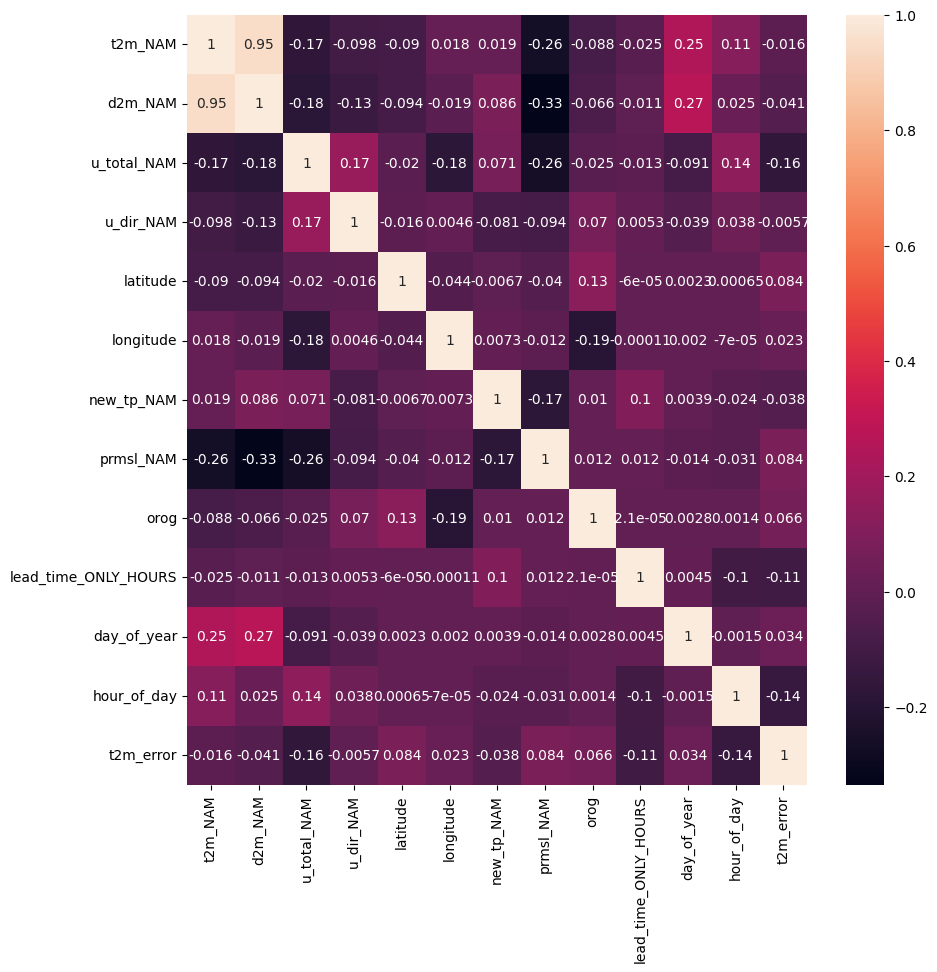

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.concat([train_features, train_dataset[["t2m_error"]]], axis=1).corr(), annot=True
)

In [17]:
train_features

t2m_NAM    d2m_NAM  u_total_NAM   u_dir_NAM   latitude  longitude  \
0       -19.759197 -22.041476     2.524576  253.840907  42.040359 -77.237259   
1       -18.046044 -21.855579     2.720024  254.779687  42.040359 -77.237259   
2       -15.787794 -21.247026     2.748936  256.181689  42.040359 -77.237259   
3       -13.674216 -20.274005     3.648439  266.826981  42.040359 -77.237259   
4       -12.322273 -19.119840     4.529253  277.166380  42.040359 -77.237259   
...            ...        ...          ...         ...        ...        ...   
6945133   0.897851  -4.229927     4.935065  273.742596  42.855042 -77.847763   
6945134   0.645794  -3.660819     4.510801  278.376103  42.855042 -77.847763   
6945135  -0.120750  -3.314855     3.545900  273.884467  42.855042 -77.847763   
6945136  -1.319672  -3.304638     2.749598  268.500187  42.855042 -77.847763   
6945137  -1.671850  -3.245341     2.294645  256.594117  42.855042 -77.847763   

         new_tp_NAM    prmsl_NAM        orog  lead_time_ONLY_HOURS  \
0               0.0  1032.341486  462.976663                   1.0   
1               0.0  1032.171616  462.976663                   2.0   
2               0.0  1031.517329  462.976663                   3.0   
3               0.0  1031.323558  462.976663                   4.0   
4               0.0  1029.892021  462.976663                   5.0   
...             ...          ...         ...                   ...   
6945133         0.0  1024.802901  275.188109                   7.0   
6945134         0.0  1025.117026  275.188109                   8.0   
6945135         0.0  1025.923777  275.188109                   9.0   
6945136         0.0  1026.312193  275.188109                  10.0   
6945137         0.0  1027.431853  275.188109                  11.0   

         day_of_year  hour_of_day  
0                  1           13  
1                  1           14  
2                  1           15  
3                  1           16  
4                  1           17  
...              ...          ...  
6945133          366           19  
6945134          366           20  
6945135          366           21  
6945136          366           22  
6945137          366           23  

[6945138 rows x 12 columns]

In [18]:
# try axis = None
# axis = -1 where the last axis of the input is assumed to be a feature dimension and is normalized per index.
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)

# Calling adapt() on a Normalization layer is an alternative to passing in mean and variance arguments during layer construction. A Normalization layer should always either be adapted over a dataset or passed mean and variance. During adapt(), the layer will compute a mean and variance separately for each position in each axis specified by the axis argument. To calculate a single mean and variance over the input data, simply pass axis=None.
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2023-05-30 17:05:59.433112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:06:00.394737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46689 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:b5:00.0, compute capability: 8.6


[[ 8.91565704e+00  4.56960392e+00  3.74629498e+00  2.07613693e+02
   4.28012238e+01 -7.54170837e+01  2.40008891e-01  1.01745935e+03
   3.05540375e+02  3.17113419e+01  1.84103836e+02  1.23627710e+01]]


In [19]:
# when the layer is called, it returns the input data, with each feature independently normalized

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print("First example:", first)
    print()
    print("Normalized:", normalizer(first).numpy())

First example: [[ -19.76  -22.04    2.52  253.84   42.04  -77.24    0.   1032.34  462.98
     1.      1.     13.  ]]

Normalized: [[-2.68 -2.52 -0.58  0.54 -0.76 -1.11 -0.22  1.84  0.93 -1.34 -1.75  0.09]]


In [20]:
train_features.keys()

Index(['t2m_NAM', 'd2m_NAM', 'u_total_NAM', 'u_dir_NAM', 'latitude',
       'longitude', 'new_tp_NAM', 'prmsl_NAM', 'orog', 'lead_time_ONLY_HOURS',
       'day_of_year', 'hour_of_day'],
      dtype='object')

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=10
)

In [22]:
X_train.shape

(5556110, 12)

In [23]:
def build_and_compile_model(norm):
    reg_rate = 0.001
    model = keras.Sequential(
        [
            norm,
            layers.Dense(1024),  # , activation='relu'),
            layers.LeakyReLU(),
            layers.BatchNormalization(),
            # layers.Dropout(0.4),
            layers.Dense(512),  # , activation='relu'),
            layers.LeakyReLU(),
            layers.BatchNormalization(),
            # layers.Dropout(0.3),
            layers.Dense(512),  # , activation='relu'),
            layers.LeakyReLU(),
            layers.BatchNormalization(),
            # layers.Dropout(0.3),
            layers.Dense(256),  # , activation='relu'),
            layers.LeakyReLU(),
            layers.BatchNormalization(),
            # layers.Dropout(0.2),
            layers.Dense(256),  # , activation='relu'),
            layers.LeakyReLU(),
            layers.BatchNormalization(),
            # layers.Dropout(0.2),
            # layers.Dropout(0.01),
            layers.Dense(128),  # , activation='relu'),
            layers.LeakyReLU(),
            # layers.Dropout(0.05),
            layers.Dense(1),
        ]
    )

    # why can't we track accuracy for regression tasks?
    # discussion here: https://machinelearningmastery.com/regression-metrics-for-machine-learning/
    model.compile(
        loss="mean_absolute_error",
        optimizer=tf.keras.optimizers.Adam(0.001)
        # optimizer=tf.keras.optimizers.Adam(lr=0.005, decay=5e-4)
    )
    return model

In [24]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              13312     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0

In [26]:
history = dnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    # callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    batch_size=100,  # 100
    verbose=1,
    epochs=5,
    callbacks=[EarlyStopping(monitor="val_loss", patience=25)],
)

Epoch 1/5
55562/55562 [==============================] - 262s 5ms/step - loss: 1.3810 - val_loss: 1.3313
Epoch 2/5
55562/55562 [==============================] - 238s 4ms/step - loss: 1.3181 - val_loss: 1.2744
Epoch 3/5
55562/55562 [==============================] - 258s 5ms/step - loss: 1.2836 - val_loss: 1.2702
Epoch 4/5
55562/55562 [==============================] - 265s 5ms/step - loss: 1.2598 - val_loss: 1.2436
Epoch 5/5
55562/55562 [==============================] - 239s 4ms/step - loss: 1.2431 - val_loss: 1.2267


In [ ]:
# dnn_model.save('../saved_model/dnn_regression_single_output_20220119')

: 

In [27]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    # plt.ylim([0, 1.])
    plt.xlabel("Epoch")
    plt.ylabel("Error [deg C]")
    plt.legend()
    plt.grid(True)

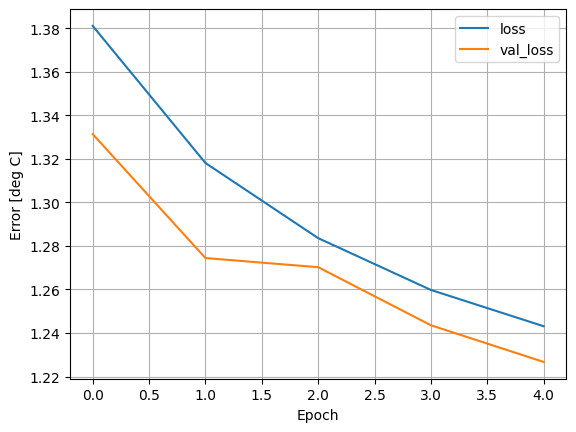

In [28]:
plot_loss(history)

In [29]:
# dnn_model.save('../saved_model/dnn_regression_single_output_DJF_20220228')
# dnn_model.save('../saved_model/dnn_regression_single_output_20220120')

In [30]:
dnn_model.evaluate(test_features, test_labels, batch_size=100)

23354/23354 [==============================] - 38s 2ms/step - loss: 1.3710


1.3709524869918823

In [31]:
test_labels.min()

t2m_error   -16.338535
dtype: float64

72981/72981 [==============================] - 96s 1ms/step


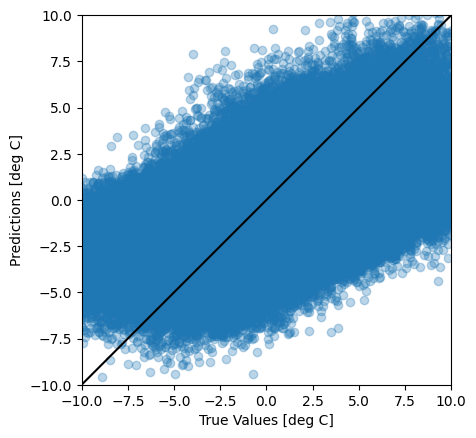

In [32]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel("True Values [deg C]")
plt.ylabel("Predictions [deg C]")
lims = [-10, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, c="k")

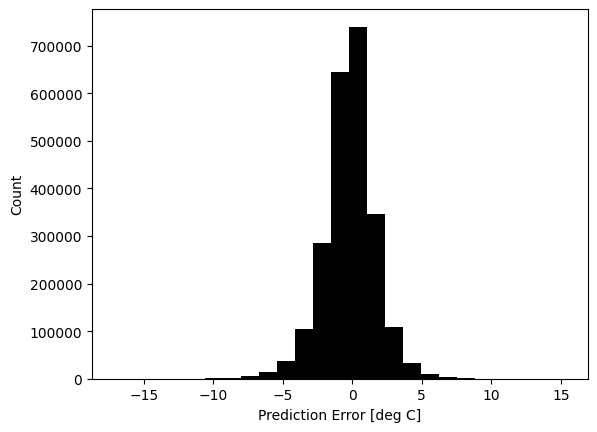

In [33]:
error = test_predictions - test_labels.to_numpy().flatten()
plt.hist(error, bins=25, color="k")
plt.xlabel("Prediction Error [deg C]")
_ = plt.ylabel("Count")